In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import map_coordinates, gaussian_filter
from sklearn.metrics import precision_recall_fscore_support
import shutil

%run '/kaggle/input/cte-model/CTE.ipynb'
%run '/kaggle/input/cte-model/dataloader_imreshape_change.ipynb'

import numpy as np
import os

torch.Size([1, 105])


In [2]:
class LabelSomCE(nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self,x,target,smoothing=0.1):
		confidence = 1.0 - smoothing
		logprobs = F.log_softmax(x,dim=-1)
		nll_loss = - logprobs.gather(dim=-1,index=target.unsqueeze(1))
		nll_loss = nll_loss.squeeze(1)
		smooth_loss = -logprobs.mean(dim=-1)
		loss = confidence * nll_loss + smoothing * smooth_loss

		return loss.mean()

def download(folder,thetarfile):
    import urllib.request
    import tarfile
    ftpstream = urllib.request.urlopen(thetarfile)
    thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
    thetarfile.extractall(folder)
    thetarfile.close()

def extract_local_tar(local_tar_path, folder):
    with tarfile.open(local_tar_path, 'r|gz') as tar:
        tar.extractall(path=folder)

def download_cerug(folder):
    local_tarfile = "/CERUG-EN-train-images.tar.gz"
    extract_local_tar(local_tarfile, folder)
    #thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-train-images.tar.gz"
    #download(folder,thetarfile)
    local_tarfile = "/CERUG-EN-test-images.tar.gz"
    extract_local_tar(local_tarfile, folder)
    #thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-test-images.tar.gz"
    #download(folder,thetarfile)

def download_firemaker(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-test-images.tar.gz"
    download(folder,thetarfile)
    
def copy_folder_contents(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    for item in os.listdir(source_folder):
        source_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)
        if os.path.isdir(source_path):
            shutil.copytree(source_path, destination_path)
        else:
            shutil.copy2(source_path, destination_path)


In [3]:
class ImageTransformer:
    def __init__(self, foldername, imgtype='png'):
        self.imgtype = imgtype
        self.folder = foldername
        self.imglist = self.get_imgList(self.folder)
        #print(f'Image list: {self.imglist}')
        #print(f'Number of images: {len(self.imglist)}')

    def get_imgList(self, folder):
        return [img for img in os.listdir(folder) if img.endswith(self.imgtype)]

    def elastic_transform(self, image, alpha, sigma):
        random_state = np.random.RandomState(None)
        shape = image.shape

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

        distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        return distorted_image

    def perspective_transform(self, image):
        width, height = image.size
        coeffs = self.find_coeffs(
            [(0, 0), (width, 0), (width, height), (0, height)],
            [(random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), height - random.randint(0, height // 4)),
             (random.randint(0, width // 4), height - random.randint(0, height // 4))]
        )
        return image.transform((width, height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

    def find_coeffs(self, pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

        A = np.matrix(matrix, dtype=float)
        B = np.array(pb).reshape(8)

        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

    def process_and_save_images(self):
        for imgfile in self.imglist:
            # Open the image
            image = Image.open(os.path.join(self.folder, imgfile)).convert('L')
            original_image = np.array(image)

            # Save original image
            original_image_filename = os.path.join(self.folder, imgfile)
            image.save(original_image_filename)

            # Elastic distortion
            elastic_image = self.elastic_transform(original_image, alpha=34, sigma=4)
            elastic_image = Image.fromarray(elastic_image).convert('L')
            elastic_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_1.' + self.imgtype)
            elastic_image.save(elastic_image_filename)

            # Perspective transformation
            perspective_image = self.perspective_transform(image)
            perspective_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_2.' + self.imgtype)
            perspective_image.save(perspective_image_filename)

----------
loading dataset CERUG-EN with images: 17106
number of writer is: 105
-*-*-*-*-*-*-*-*-*-*
----------
loading dataset CERUG-EN with images: 5127
number of writer is: 105
-*-*-*-*-*-*-*-*-*-*
Traing epoch: 0   avg loss is: 7.750371350876297


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 0   avg testing loss is: 3.9258241957964555
Testing on epoch: 0 has accuracy: top1: 20.42 top5: 58.65
Precision: 24.40%, Recall: 21.13%, F1 Score: 16.20%


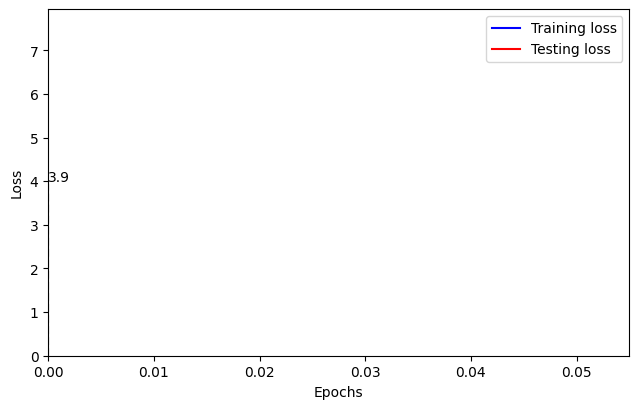

Traing epoch: 1   avg loss is: 4.768905228828023


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 1   avg testing loss is: 3.2992152803783474
Testing on epoch: 1 has accuracy: top1: 34.64 top5: 69.65
Precision: 43.04%, Recall: 35.18%, F1 Score: 29.29%


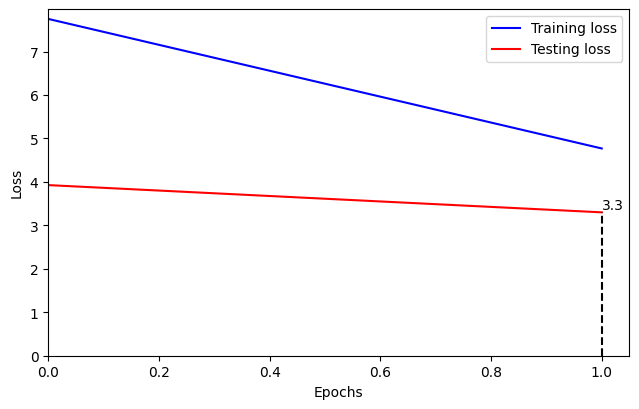

Traing epoch: 2   avg loss is: 3.5489237741179505


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 2   avg testing loss is: 2.913775680963867
Testing on epoch: 2 has accuracy: top1: 41.64 top5: 77.76
Precision: 57.13%, Recall: 41.85%, F1 Score: 38.54%


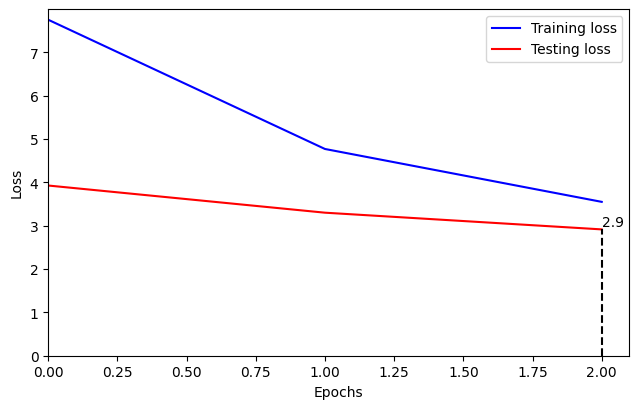

Traing epoch: 3   avg loss is: 2.743557156303199


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 3   avg testing loss is: 2.6490841023275786
Testing on epoch: 3 has accuracy: top1: 49.15 top5: 80.40
Precision: 60.80%, Recall: 49.15%, F1 Score: 44.72%


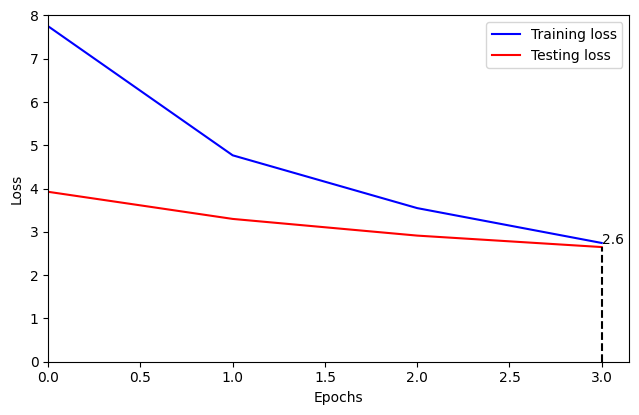

Traing epoch: 4   avg loss is: 2.3519995516990253


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 4   avg testing loss is: 2.240966217540135
Testing on epoch: 4 has accuracy: top1: 56.80 top5: 89.55
Precision: 72.26%, Recall: 57.13%, F1 Score: 57.16%


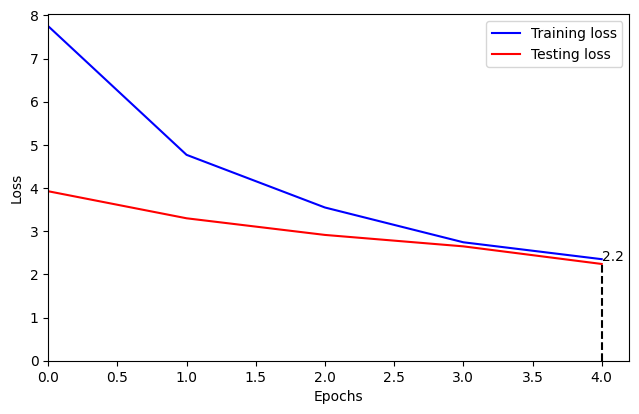

Traing epoch: 5   avg loss is: 2.1107787929816824
Testing epoch: 5   avg testing loss is: 1.9216893759100608
Testing on epoch: 5 has accuracy: top1: 68.21 top5: 93.39
Precision: 75.11%, Recall: 68.38%, F1 Score: 66.69%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


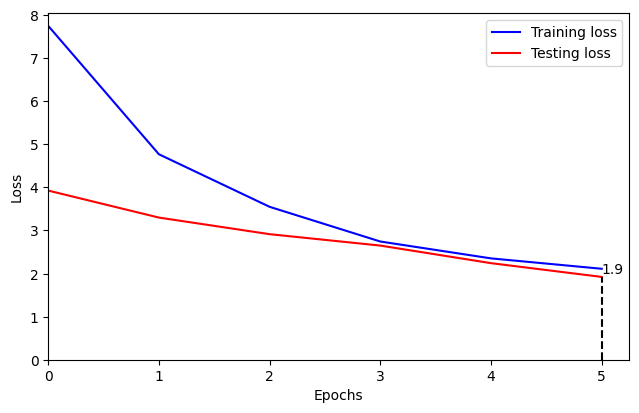

Traing epoch: 6   avg loss is: 1.9561836571198294


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 6   avg testing loss is: 2.948060087697157
Testing on epoch: 6 has accuracy: top1: 41.49 top5: 76.18
Precision: 54.94%, Recall: 41.85%, F1 Score: 39.58%


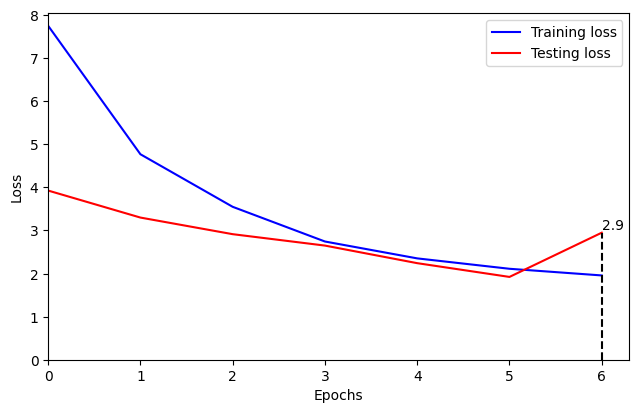

Traing epoch: 7   avg loss is: 1.8307784286138609


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 7   avg testing loss is: 2.5767976294425416
Testing on epoch: 7 has accuracy: top1: 48.68 top5: 82.45
Precision: 67.93%, Recall: 48.89%, F1 Score: 47.42%


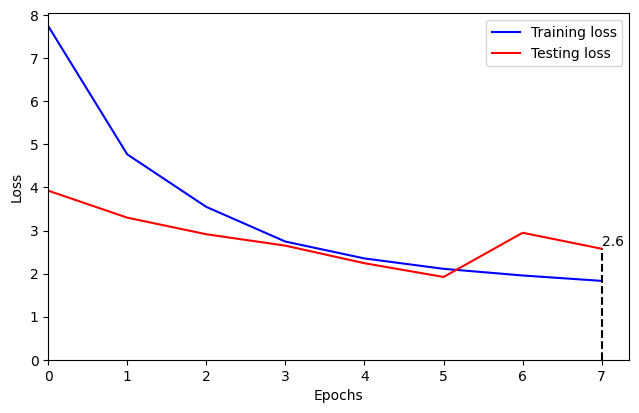

Traing epoch: 8   avg loss is: 1.7180869398661258
Testing epoch: 8   avg testing loss is: 1.8206783911892186
Testing on epoch: 8 has accuracy: top1: 70.55 top5: 94.34
Precision: 80.14%, Recall: 70.79%, F1 Score: 70.37%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


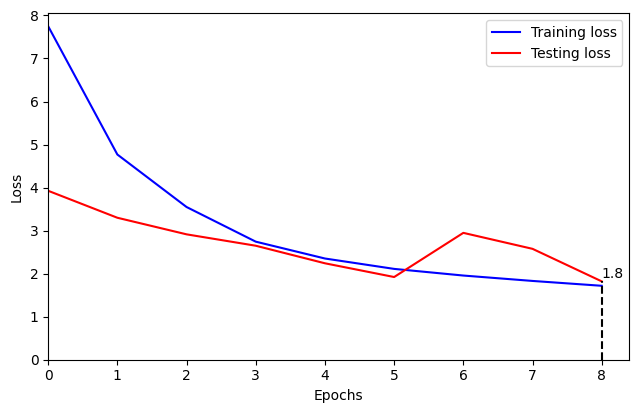

Traing epoch: 9   avg loss is: 1.6188625794242095
Testing epoch: 9   avg testing loss is: 2.06892428331286
Testing on epoch: 9 has accuracy: top1: 62.18 top5: 92.30
Precision: 76.80%, Recall: 62.38%, F1 Score: 62.17%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


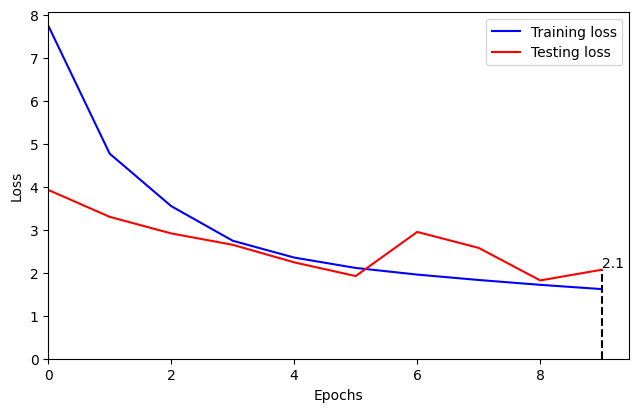

Traing epoch: 10   avg loss is: 1.371999196631536
Testing epoch: 10   avg testing loss is: 1.6474658692737234
Testing on epoch: 10 has accuracy: top1: 75.93 top5: 95.69
Precision: 81.27%, Recall: 76.28%, F1 Score: 76.04%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


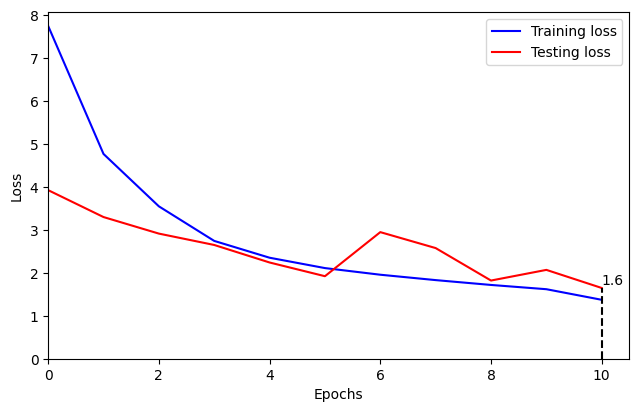

Traing epoch: 11   avg loss is: 1.3195432120109964


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1

Testing epoch: 11   avg testing loss is: 2.2673302406091187
Testing on epoch: 11 has accuracy: top1: 59.06 top5: 85.35
Precision: 68.88%, Recall: 59.23%, F1 Score: 56.41%


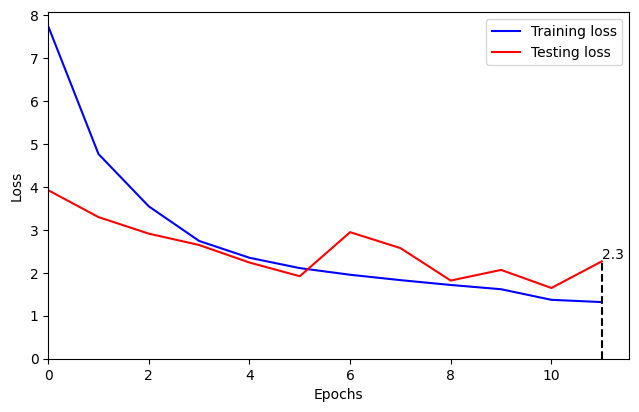

Traing epoch: 12   avg loss is: 1.281586721525558
Testing epoch: 12   avg testing loss is: 1.5149092432865845
Testing on epoch: 12 has accuracy: top1: 79.38 top5: 97.09
Precision: 83.38%, Recall: 79.60%, F1 Score: 79.52%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


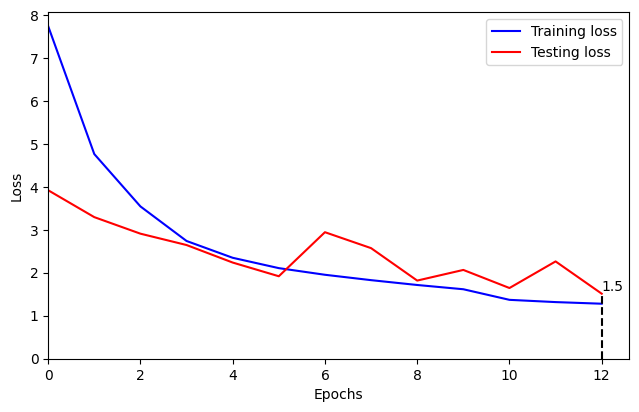

Traing epoch: 13   avg loss is: 1.246723766467413
Testing epoch: 13   avg testing loss is: 1.5120854240340236
Testing on epoch: 13 has accuracy: top1: 80.57 top5: 96.68
Precision: 84.82%, Recall: 80.51%, F1 Score: 80.29%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


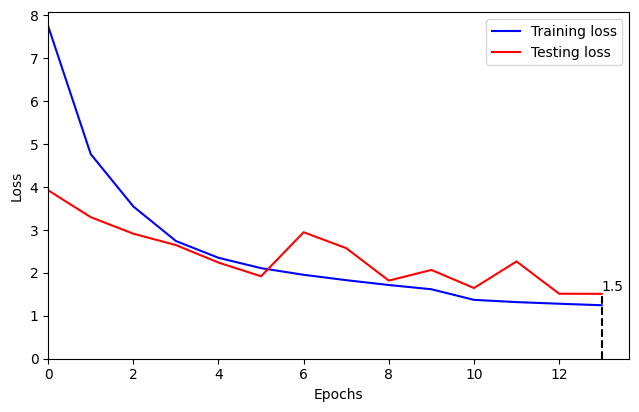

Traing epoch: 14   avg loss is: 1.2142659425735474
Testing epoch: 14   avg testing loss is: 1.6027527367957284
Testing on epoch: 14 has accuracy: top1: 77.61 top5: 95.59
Precision: 81.90%, Recall: 77.77%, F1 Score: 77.20%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


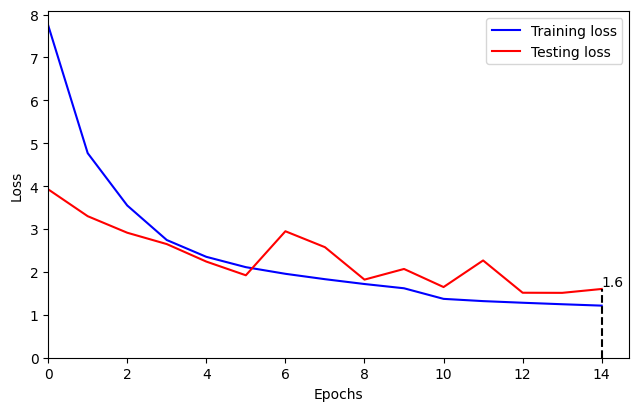

Traing epoch: 15   avg loss is: 1.1895803039156465
Testing epoch: 15   avg testing loss is: 1.4913582385886124
Testing on epoch: 15 has accuracy: top1: 80.77 top5: 96.84
Precision: 84.85%, Recall: 80.76%, F1 Score: 80.55%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


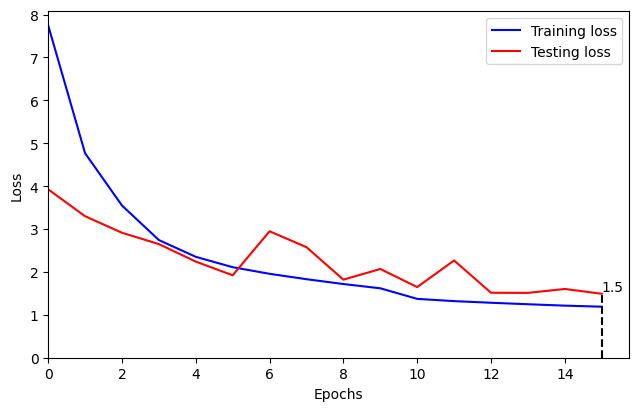

Traing epoch: 16   avg loss is: 1.166005225857359
Testing epoch: 16   avg testing loss is: 1.4356319937750557
Testing on epoch: 16 has accuracy: top1: 82.58 top5: 97.41
Precision: 85.86%, Recall: 82.80%, F1 Score: 82.77%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


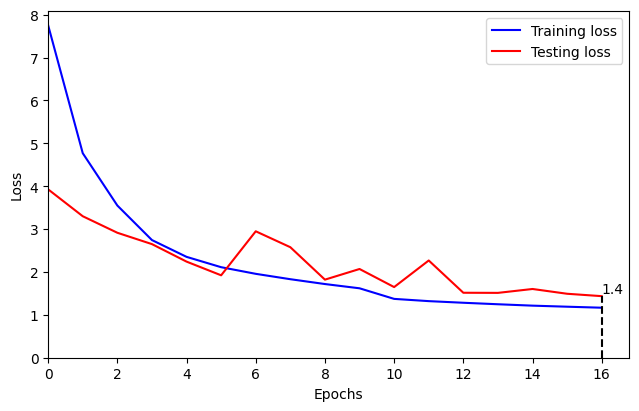

Traing epoch: 17   avg loss is: 1.1324749394373095
Testing epoch: 17   avg testing loss is: 1.5116053960776403
Testing on epoch: 17 has accuracy: top1: 81.00 top5: 96.80
Precision: 85.50%, Recall: 81.30%, F1 Score: 81.03%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


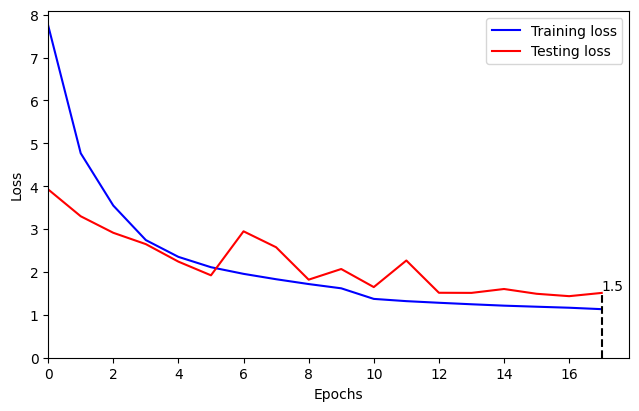

Traing epoch: 18   avg loss is: 1.1201144682123239
Testing epoch: 18   avg testing loss is: 1.6067384986491218
Testing on epoch: 18 has accuracy: top1: 77.08 top5: 95.40
Precision: 83.61%, Recall: 77.37%, F1 Score: 77.18%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


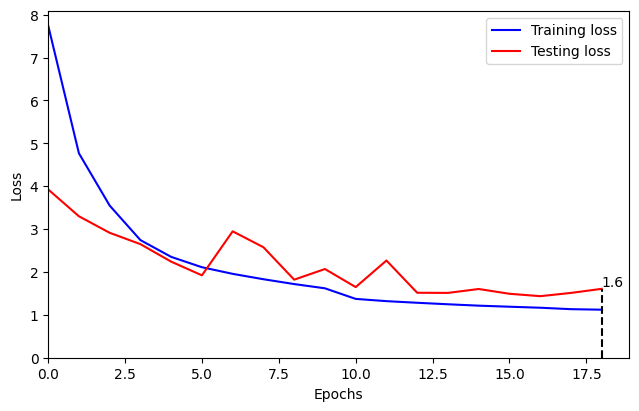

Traing epoch: 19   avg loss is: 1.1008599034751878
Testing epoch: 19   avg testing loss is: 1.4331594159669965
Testing on epoch: 19 has accuracy: top1: 82.48 top5: 97.29
Precision: 85.51%, Recall: 82.45%, F1 Score: 82.38%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


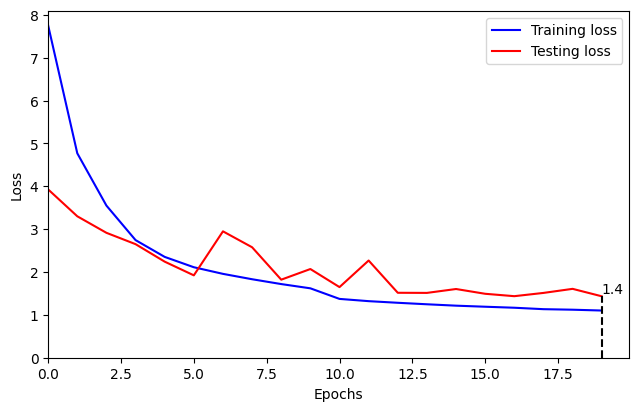

Traing epoch: 20   avg loss is: 1.0147939722486699
Testing epoch: 20   avg testing loss is: 1.2978095521808042
Testing on epoch: 20 has accuracy: top1: 87.05 top5: 97.89
Precision: 88.13%, Recall: 87.23%, F1 Score: 87.06%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


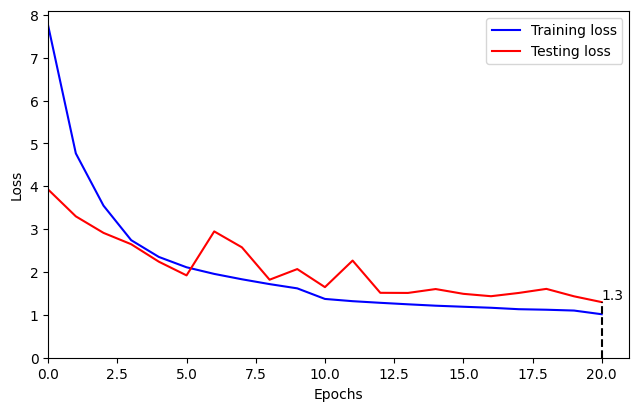

Traing epoch: 21   avg loss is: 0.9969042816710763
Testing epoch: 21   avg testing loss is: 1.3264460671356535
Testing on epoch: 21 has accuracy: top1: 85.94 top5: 97.74
Precision: 87.63%, Recall: 86.13%, F1 Score: 85.91%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


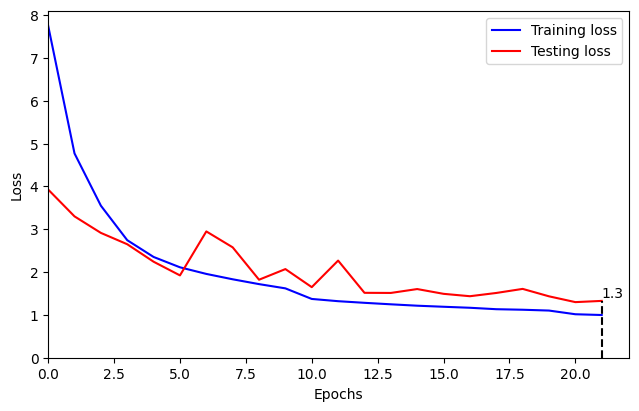

Traing epoch: 22   avg loss is: 0.9886308968680501
Testing epoch: 22   avg testing loss is: 1.276075749382423
Testing on epoch: 22 has accuracy: top1: 87.61 top5: 98.01
Precision: 88.66%, Recall: 87.68%, F1 Score: 87.48%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


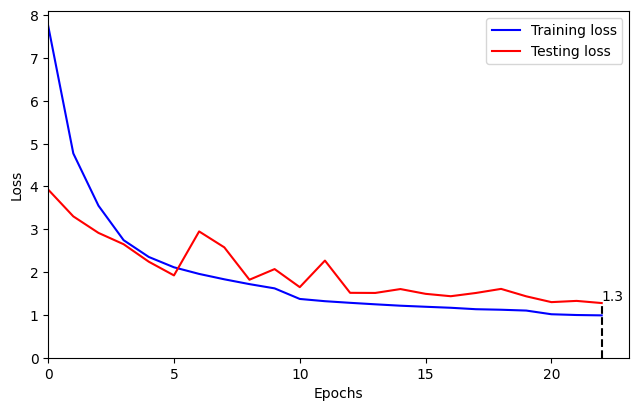

Traing epoch: 23   avg loss is: 0.9816159987918008
Testing epoch: 23   avg testing loss is: 1.386155270341772
Testing on epoch: 23 has accuracy: top1: 84.01 top5: 96.90
Precision: 86.75%, Recall: 84.16%, F1 Score: 83.95%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


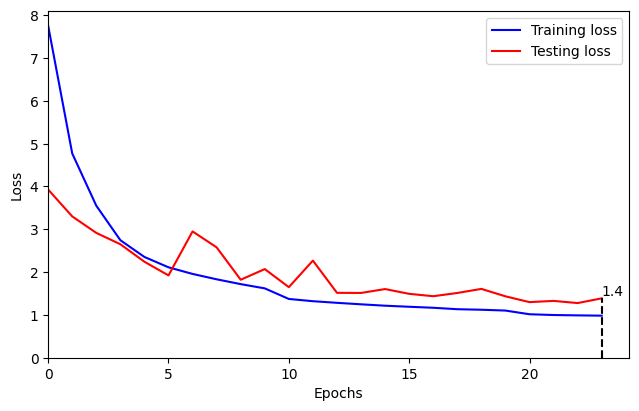

Traing epoch: 24   avg loss is: 0.9708162530545769
Testing epoch: 24   avg testing loss is: 1.317785597664545
Testing on epoch: 24 has accuracy: top1: 85.98 top5: 97.97
Precision: 87.88%, Recall: 86.13%, F1 Score: 86.04%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


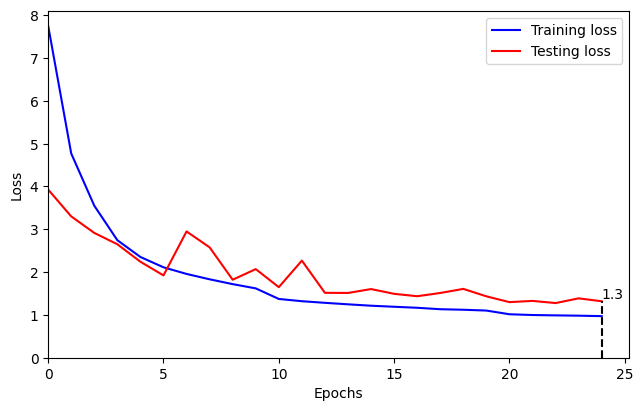

Traing epoch: 25   avg loss is: 0.964898146180152
Testing epoch: 25   avg testing loss is: 1.3348385920034391
Testing on epoch: 25 has accuracy: top1: 85.12 top5: 97.66
Precision: 87.11%, Recall: 85.34%, F1 Score: 85.07%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


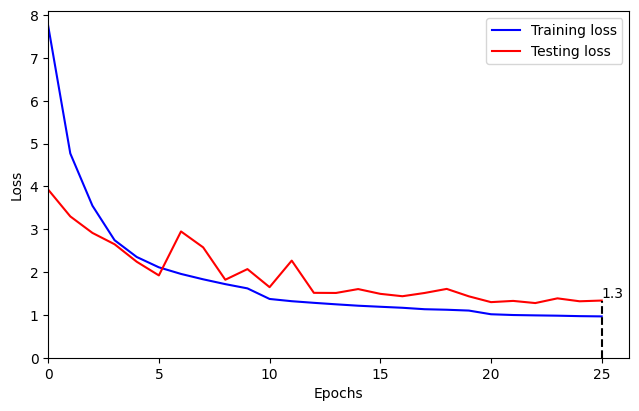

Traing epoch: 26   avg loss is: 0.9556047987781806
Testing epoch: 26   avg testing loss is: 1.4187612823236768
Testing on epoch: 26 has accuracy: top1: 82.56 top5: 96.74
Precision: 85.26%, Recall: 82.67%, F1 Score: 82.32%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


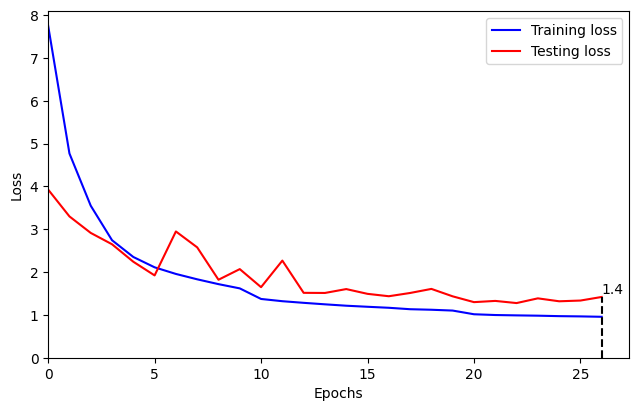

Traing epoch: 27   avg loss is: 0.9497679594078278
Testing epoch: 27   avg testing loss is: 1.3391228511326039
Testing on epoch: 27 has accuracy: top1: 85.12 top5: 97.29
Precision: 87.35%, Recall: 85.29%, F1 Score: 85.18%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


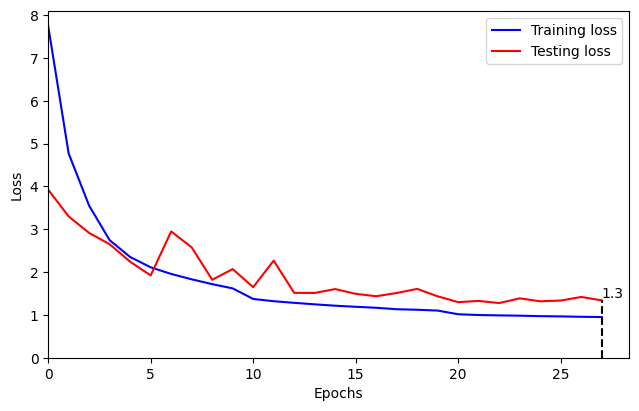

Traing epoch: 28   avg loss is: 0.9440731627011099
Testing epoch: 28   avg testing loss is: 1.3348985104545998
Testing on epoch: 28 has accuracy: top1: 85.45 top5: 97.83
Precision: 87.12%, Recall: 85.66%, F1 Score: 85.42%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


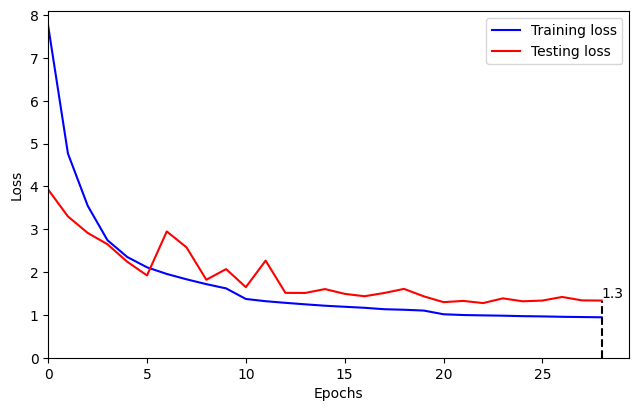

Traing epoch: 29   avg loss is: 0.9397116855442023
Testing epoch: 29   avg testing loss is: 1.4240552502629171
Testing on epoch: 29 has accuracy: top1: 82.93 top5: 96.63
Precision: 86.90%, Recall: 82.90%, F1 Score: 82.96%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


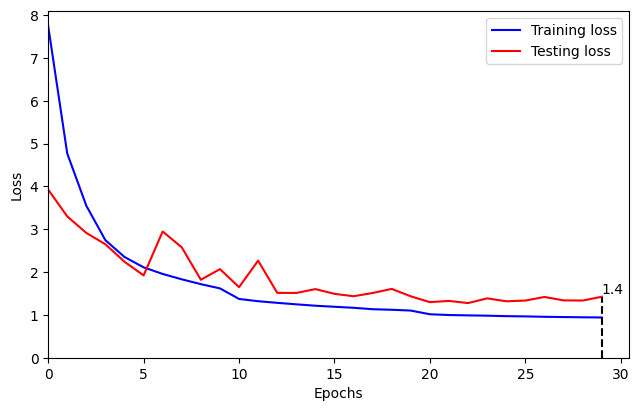

Traing epoch: 30   avg loss is: 0.9097284307203302
Testing epoch: 30   avg testing loss is: 1.263405248940548
Testing on epoch: 30 has accuracy: top1: 87.87 top5: 98.19
Precision: 89.00%, Recall: 88.01%, F1 Score: 87.91%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


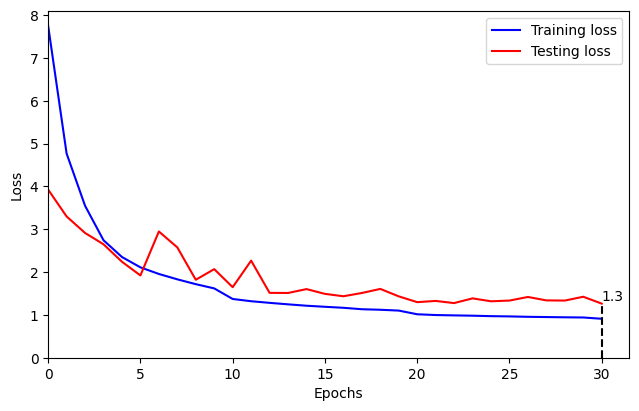

Traing epoch: 31   avg loss is: 0.9039580340804733
Testing epoch: 31   avg testing loss is: 1.2450191831663018
Testing on epoch: 31 has accuracy: top1: 88.20 top5: 98.11
Precision: 89.15%, Recall: 88.44%, F1 Score: 88.21%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


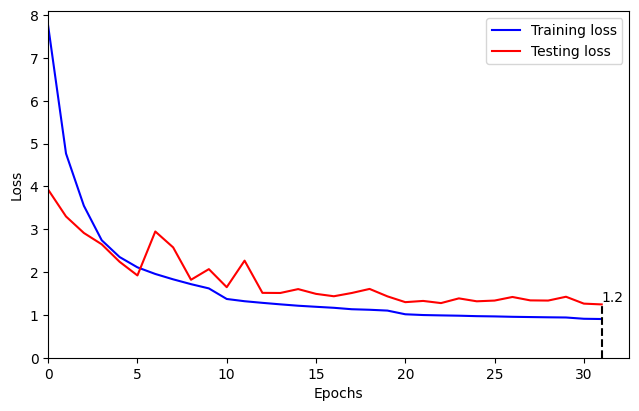

Traing epoch: 32   avg loss is: 0.9031429666576261
Testing epoch: 32   avg testing loss is: 1.3031510987385782
Testing on epoch: 32 has accuracy: top1: 86.41 top5: 97.66
Precision: 89.12%, Recall: 86.67%, F1 Score: 86.74%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


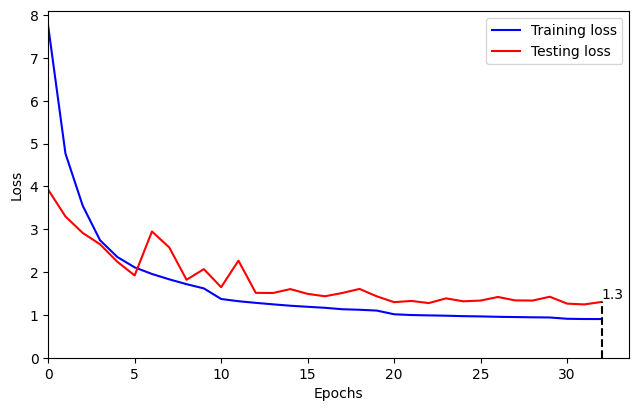

Traing epoch: 33   avg loss is: 0.8996477483364886
Testing epoch: 33   avg testing loss is: 1.2382224192871853
Testing on epoch: 33 has accuracy: top1: 88.61 top5: 98.38
Precision: 89.38%, Recall: 88.75%, F1 Score: 88.55%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


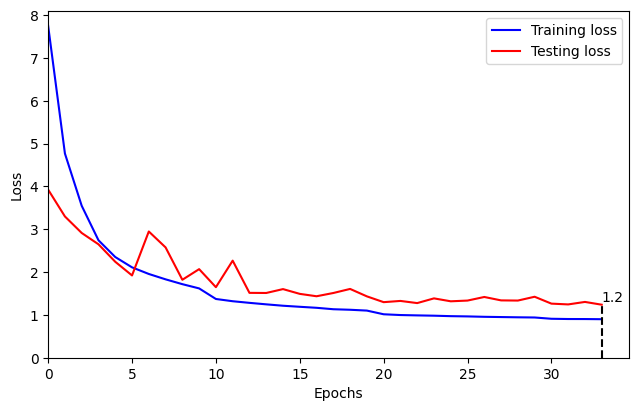

Traing epoch: 34   avg loss is: 0.8959374553249527
Testing epoch: 34   avg testing loss is: 1.2725826251172574
Testing on epoch: 34 has accuracy: top1: 87.40 top5: 98.15
Precision: 88.47%, Recall: 87.52%, F1 Score: 87.31%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


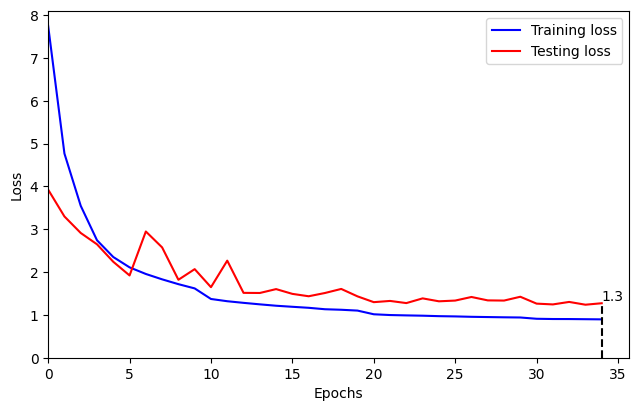

Traing epoch: 35   avg loss is: 0.8927638771045532
Testing epoch: 35   avg testing loss is: 1.294590406885771
Testing on epoch: 35 has accuracy: top1: 86.41 top5: 97.89
Precision: 88.17%, Recall: 86.61%, F1 Score: 86.50%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


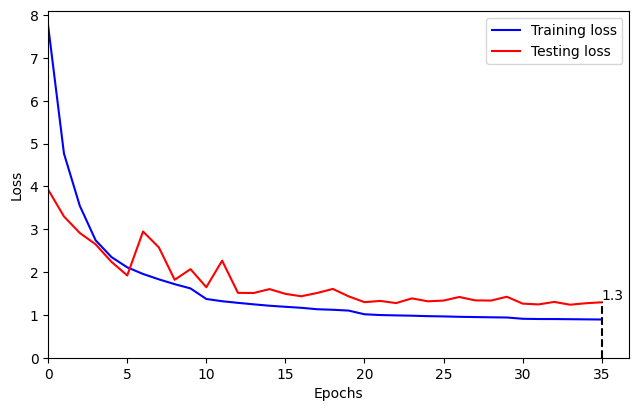

Traing epoch: 36   avg loss is: 0.8905885137053045
Testing epoch: 36   avg testing loss is: 1.2700712638109273
Testing on epoch: 36 has accuracy: top1: 87.52 top5: 98.19
Precision: 88.94%, Recall: 87.75%, F1 Score: 87.57%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


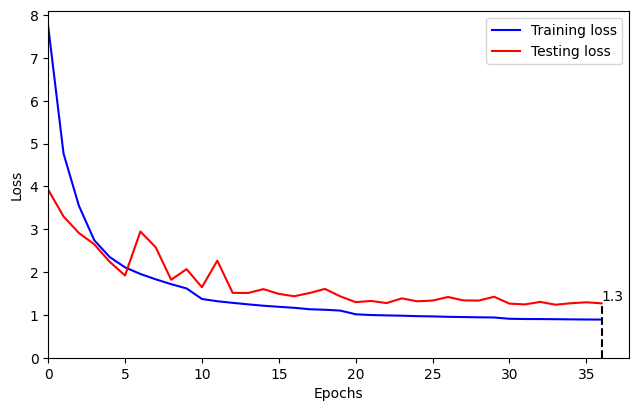

Traing epoch: 37   avg loss is: 0.8881775115671505
Testing epoch: 37   avg testing loss is: 1.2551037448217564
Testing on epoch: 37 has accuracy: top1: 87.83 top5: 98.30
Precision: 88.77%, Recall: 88.01%, F1 Score: 87.79%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


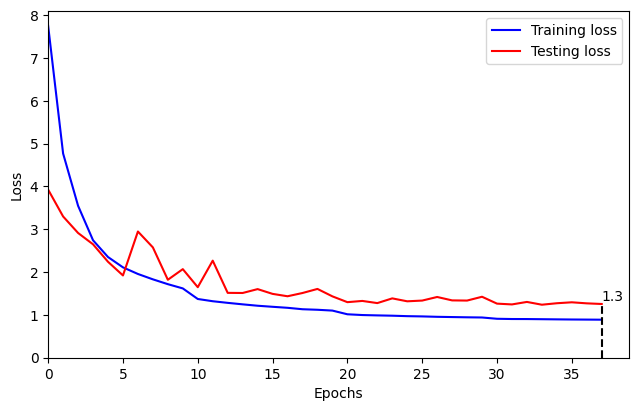

Traing epoch: 38   avg loss is: 0.8865000864855032
Testing epoch: 38   avg testing loss is: 1.2529674185399327
Testing on epoch: 38 has accuracy: top1: 88.02 top5: 98.36
Precision: 89.11%, Recall: 88.18%, F1 Score: 87.92%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


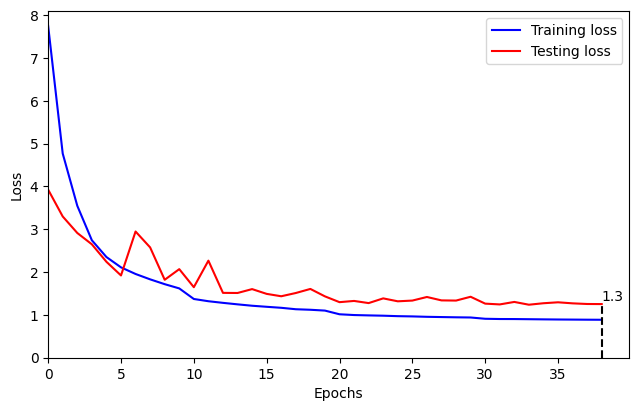

Traing epoch: 39   avg loss is: 0.8847999329651707
Testing epoch: 39   avg testing loss is: 1.2747033802891075
Testing on epoch: 39 has accuracy: top1: 87.24 top5: 98.03
Precision: 88.65%, Recall: 87.42%, F1 Score: 87.25%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


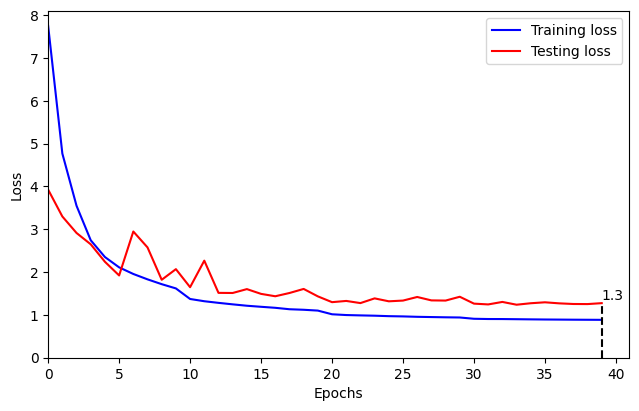

Traing epoch: 40   avg loss is: 0.8751159498243269
Testing epoch: 40   avg testing loss is: 1.2471453790724092
Testing on epoch: 40 has accuracy: top1: 88.53 top5: 98.36
Precision: 89.41%, Recall: 88.73%, F1 Score: 88.49%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


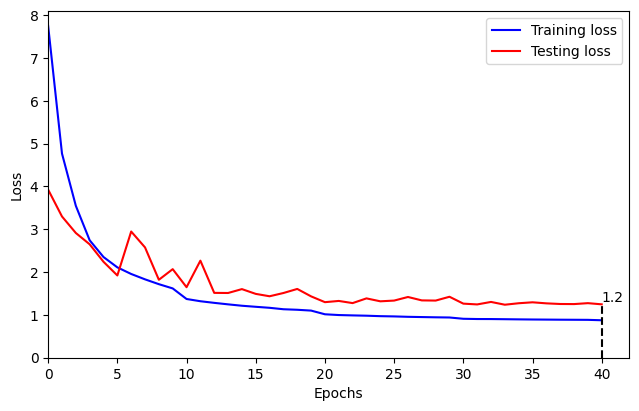

Traing epoch: 41   avg loss is: 0.871597368712733
Testing epoch: 41   avg testing loss is: 1.2239432180781973
Testing on epoch: 41 has accuracy: top1: 89.14 top5: 98.30
Precision: 89.84%, Recall: 89.31%, F1 Score: 89.09%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


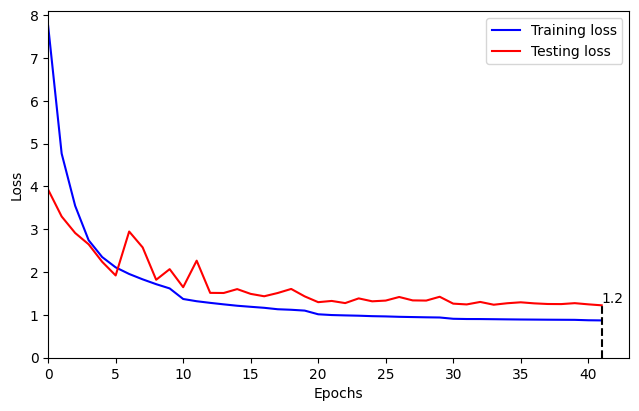

Traing epoch: 42   avg loss is: 0.8704666113942666
Testing epoch: 42   avg testing loss is: 1.2417527062127895
Testing on epoch: 42 has accuracy: top1: 89.21 top5: 98.24
Precision: 89.97%, Recall: 89.37%, F1 Score: 89.20%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


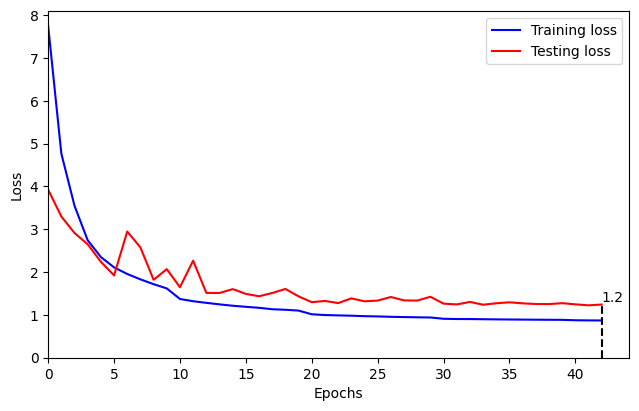

Traing epoch: 43   avg loss is: 0.8697339668242702
Testing epoch: 43   avg testing loss is: 1.2450983297787723
Testing on epoch: 43 has accuracy: top1: 88.71 top5: 98.24
Precision: 89.47%, Recall: 88.92%, F1 Score: 88.65%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


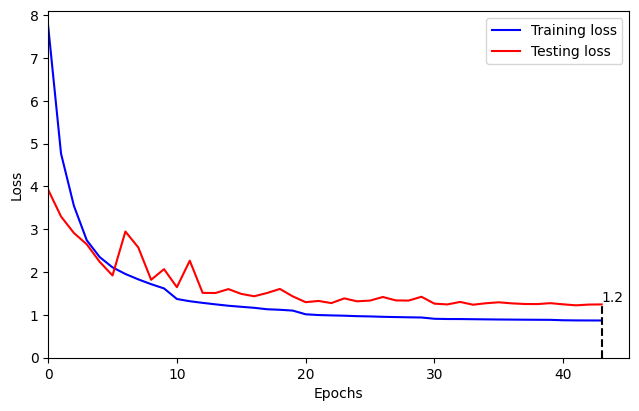

Traing epoch: 44   avg loss is: 0.8695749913118397
Testing epoch: 44   avg testing loss is: 1.234141965707143
Testing on epoch: 44 has accuracy: top1: 88.96 top5: 98.40
Precision: 89.79%, Recall: 89.07%, F1 Score: 88.97%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


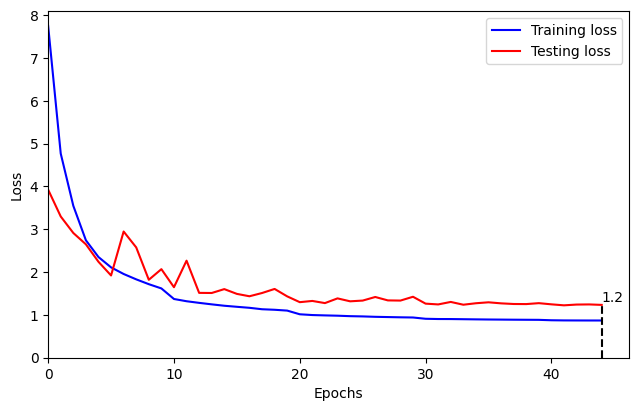

Traing epoch: 45   avg loss is: 0.8669537607479363
Testing epoch: 45   avg testing loss is: 1.2454261206020818
Testing on epoch: 45 has accuracy: top1: 88.82 top5: 98.23
Precision: 89.58%, Recall: 88.98%, F1 Score: 88.76%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


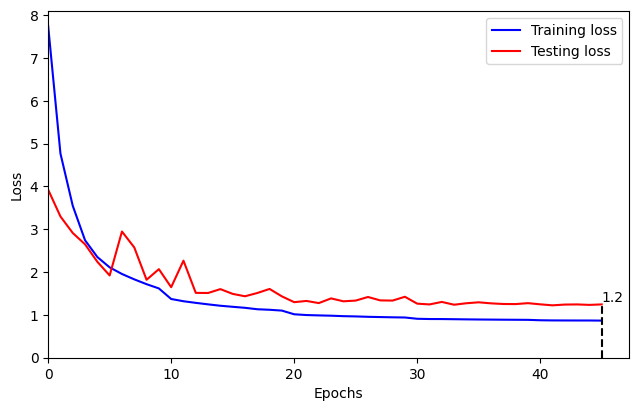

Traing epoch: 46   avg loss is: 0.8667259354586909
Testing epoch: 46   avg testing loss is: 1.2678842256745073
Testing on epoch: 46 has accuracy: top1: 87.56 top5: 98.09
Precision: 88.76%, Recall: 87.75%, F1 Score: 87.52%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


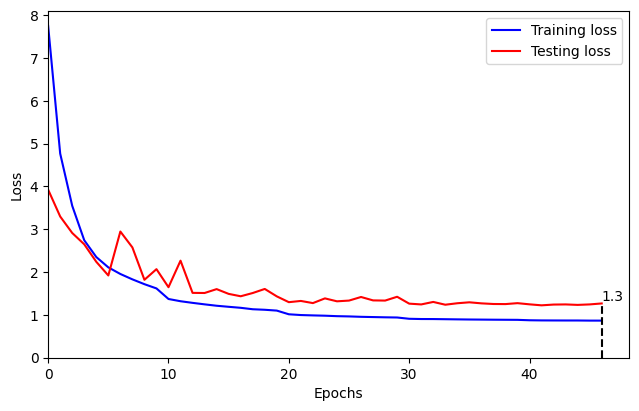

Traing epoch: 47   avg loss is: 0.8654722892535525
Testing epoch: 47   avg testing loss is: 1.239742523041841
Testing on epoch: 47 has accuracy: top1: 89.00 top5: 98.40
Precision: 89.75%, Recall: 89.08%, F1 Score: 88.96%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


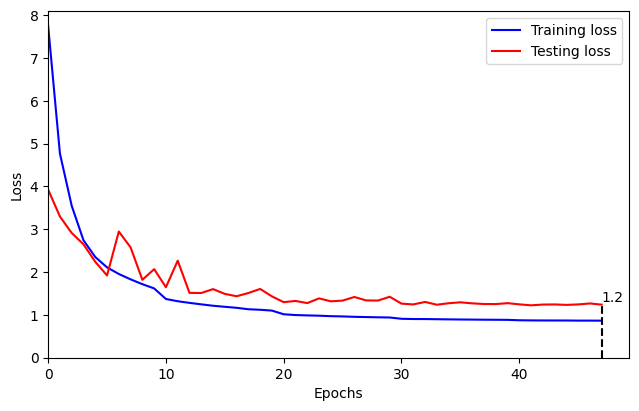

Traing epoch: 48   avg loss is: 0.8649733226024959
Testing epoch: 48   avg testing loss is: 1.2448021283030881
Testing on epoch: 48 has accuracy: top1: 88.47 top5: 98.24
Precision: 89.55%, Recall: 88.57%, F1 Score: 88.47%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


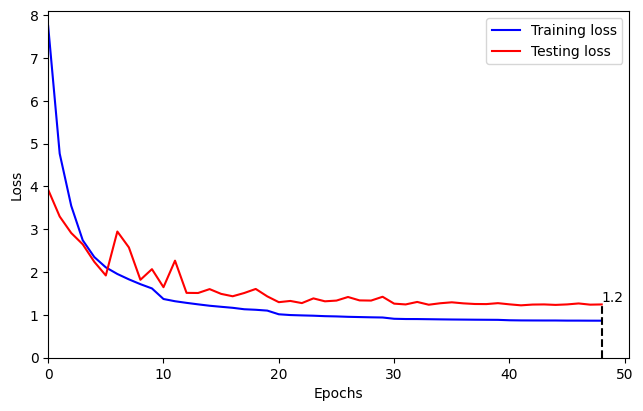

Traing epoch: 49   avg loss is: 0.8625901280105169
Testing epoch: 49   avg testing loss is: 1.269663951292959
Testing on epoch: 49 has accuracy: top1: 87.83 top5: 98.13
Precision: 88.83%, Recall: 87.96%, F1 Score: 87.76%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


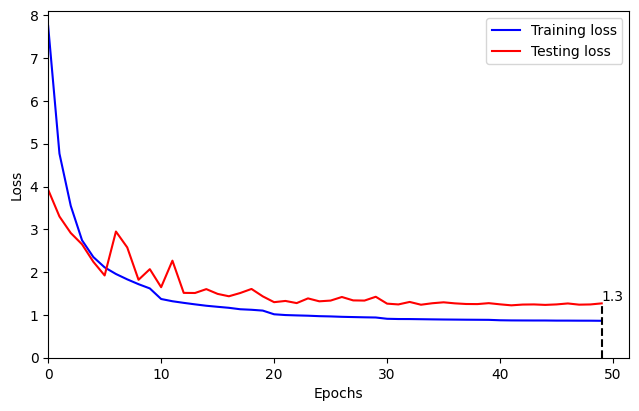

Traing epoch: 50   avg loss is: 0.8599181116686679
Testing epoch: 50   avg testing loss is: 1.2551966420957976
Testing on epoch: 50 has accuracy: top1: 88.51 top5: 98.26
Precision: 89.36%, Recall: 88.68%, F1 Score: 88.48%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


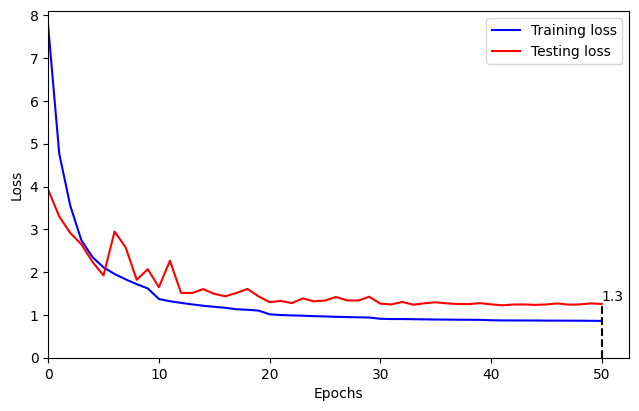

Traing epoch: 51   avg loss is: 0.8585207102675656
Testing epoch: 51   avg testing loss is: 1.307044378322233
Testing on epoch: 51 has accuracy: top1: 86.83 top5: 97.87
Precision: 88.17%, Recall: 87.01%, F1 Score: 86.76%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


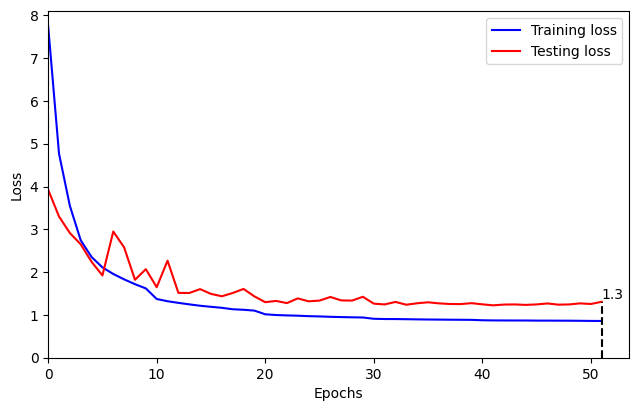

Traing epoch: 52   avg loss is: 0.8575459905491464
Testing epoch: 52   avg testing loss is: 1.237543718094395
Testing on epoch: 52 has accuracy: top1: 88.92 top5: 98.50
Precision: 89.69%, Recall: 89.08%, F1 Score: 88.83%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


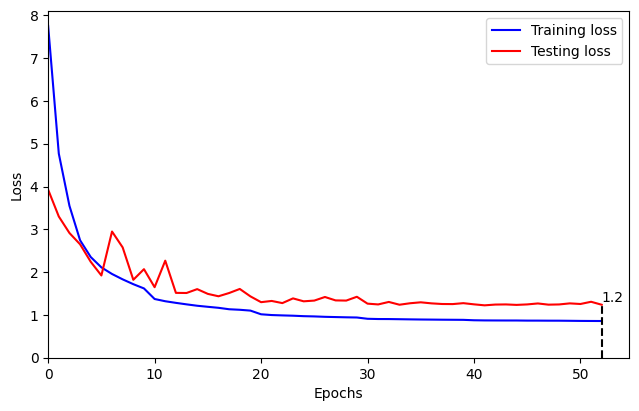

Traing epoch: 53   avg loss is: 0.8560747213738337
Testing epoch: 53   avg testing loss is: 1.2563761546975727
Testing on epoch: 53 has accuracy: top1: 88.59 top5: 98.34
Precision: 89.34%, Recall: 88.74%, F1 Score: 88.55%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


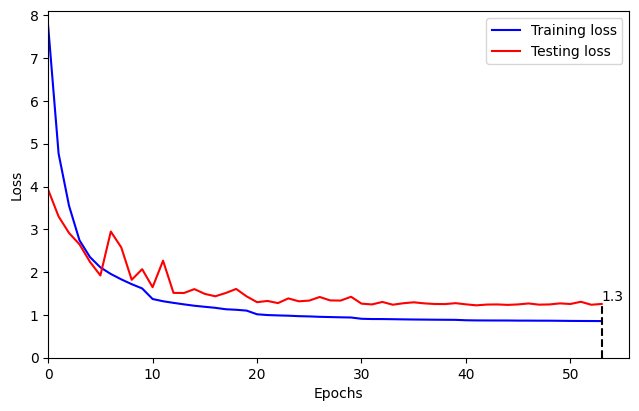

Traing epoch: 54   avg loss is: 0.856707166521431
Testing epoch: 54   avg testing loss is: 1.232600933851854
Testing on epoch: 54 has accuracy: top1: 89.29 top5: 98.42
Precision: 90.01%, Recall: 89.48%, F1 Score: 89.27%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


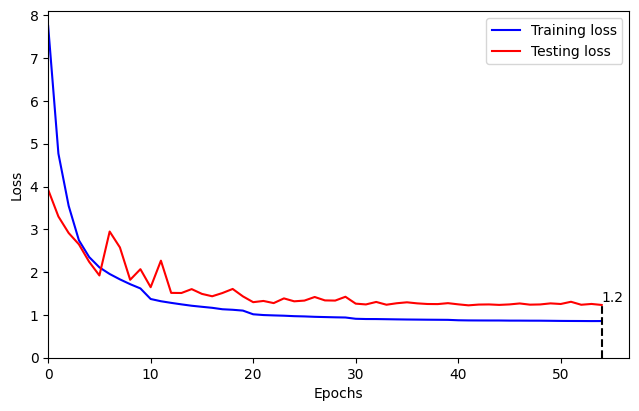

Traing epoch: 55   avg loss is: 0.8557271085351956
Testing epoch: 55   avg testing loss is: 1.2385155627289293
Testing on epoch: 55 has accuracy: top1: 89.25 top5: 98.54
Precision: 90.14%, Recall: 89.44%, F1 Score: 89.28%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


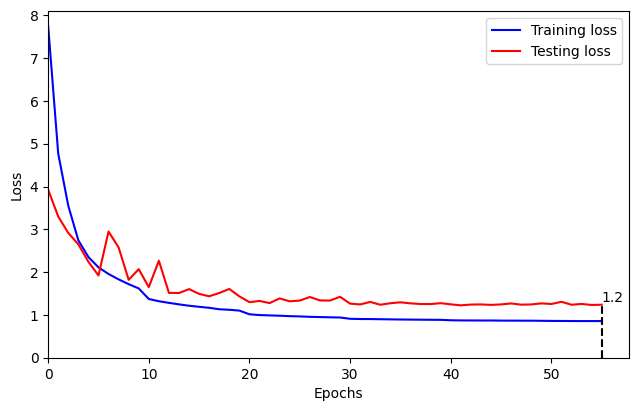

Traing epoch: 56   avg loss is: 0.8556544406599147
Testing epoch: 56   avg testing loss is: 1.229702594867005
Testing on epoch: 56 has accuracy: top1: 89.39 top5: 98.42
Precision: 90.03%, Recall: 89.58%, F1 Score: 89.38%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


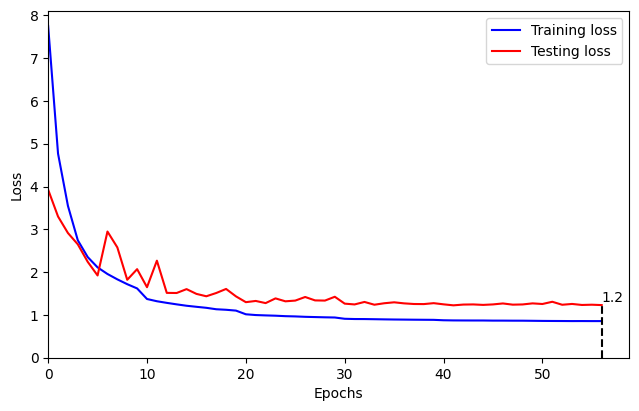

Traing epoch: 57   avg loss is: 0.8544752869347304
Testing epoch: 57   avg testing loss is: 1.2459731176263447
Testing on epoch: 57 has accuracy: top1: 89.49 top5: 98.32
Precision: 90.11%, Recall: 89.66%, F1 Score: 89.45%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


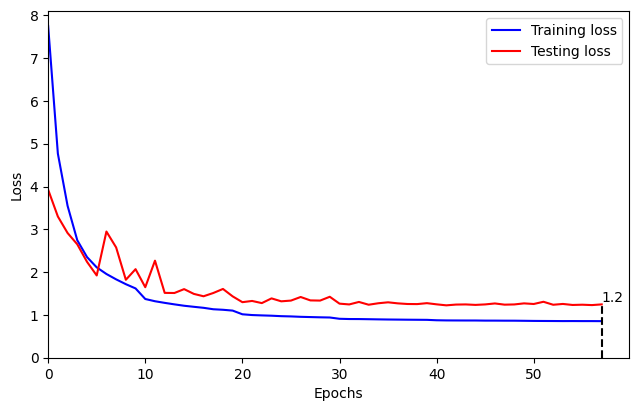

Traing epoch: 58   avg loss is: 0.8551702971097127
Testing epoch: 58   avg testing loss is: 1.2645138045337712
Testing on epoch: 58 has accuracy: top1: 88.41 top5: 98.23
Precision: 89.35%, Recall: 88.61%, F1 Score: 88.41%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


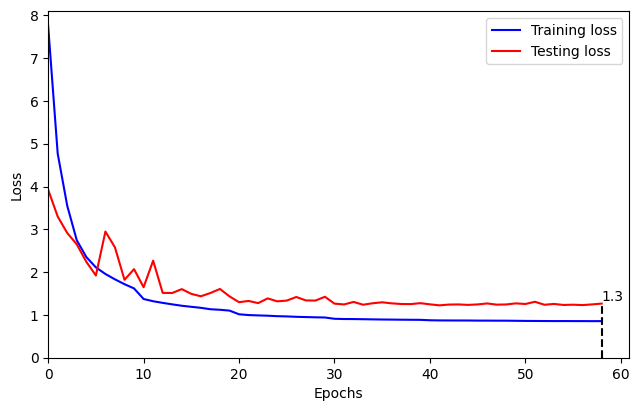

Traing epoch: 59   avg loss is: 0.8534628054714292
Testing epoch: 59   avg testing loss is: 1.22897934727951
Testing on epoch: 59 has accuracy: top1: 89.23 top5: 98.28
Precision: 89.98%, Recall: 89.44%, F1 Score: 89.25%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


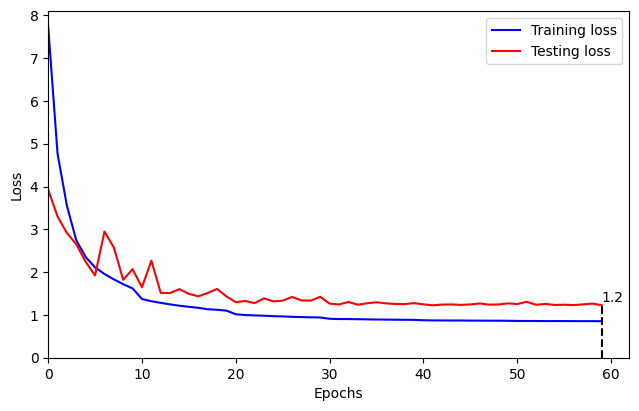

Traing epoch: 60   avg loss is: 0.8522978671473582
Testing epoch: 60   avg testing loss is: 1.2417102827461337
Testing on epoch: 60 has accuracy: top1: 89.21 top5: 98.44
Precision: 89.96%, Recall: 89.41%, F1 Score: 89.22%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


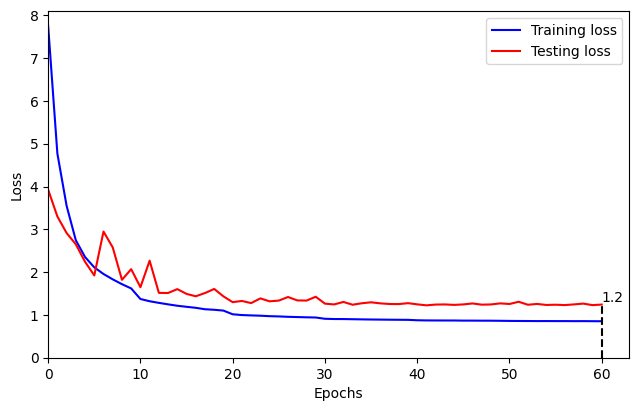

Traing epoch: 61   avg loss is: 0.8511530563472252
Testing epoch: 61   avg testing loss is: 1.235732583984779
Testing on epoch: 61 has accuracy: top1: 89.55 top5: 98.38
Precision: 90.31%, Recall: 89.70%, F1 Score: 89.52%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


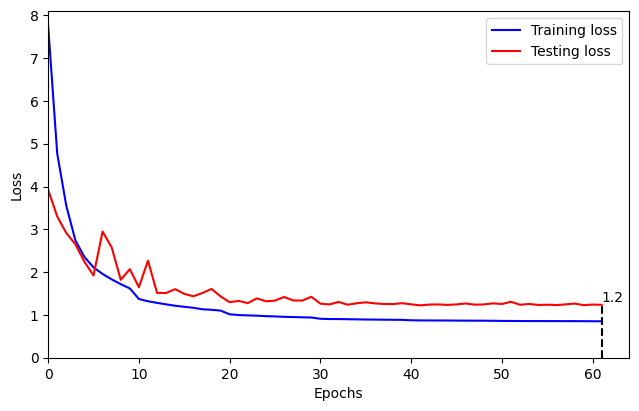

Traing epoch: 62   avg loss is: 0.8518799052158174
Testing epoch: 62   avg testing loss is: 1.2426919209251523
Testing on epoch: 62 has accuracy: top1: 89.21 top5: 98.40
Precision: 89.98%, Recall: 89.37%, F1 Score: 89.20%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


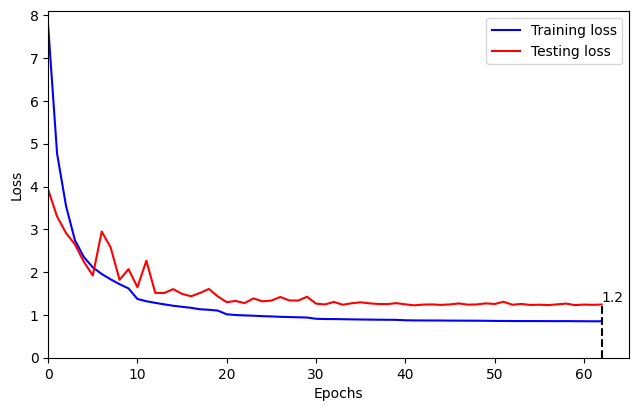

Traing epoch: 63   avg loss is: 0.8516397416535887
Testing epoch: 63   avg testing loss is: 1.2351844123219404
Testing on epoch: 63 has accuracy: top1: 89.58 top5: 98.46
Precision: 90.27%, Recall: 89.75%, F1 Score: 89.57%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


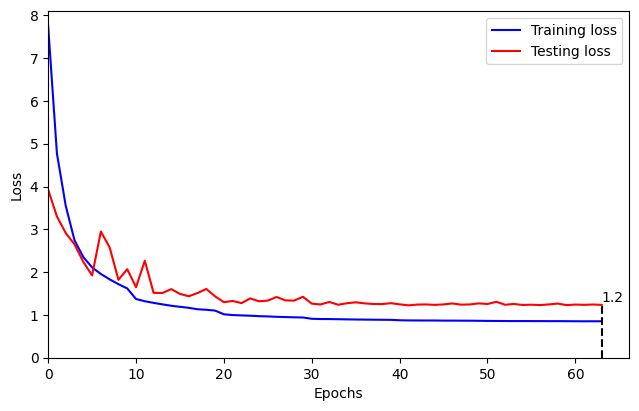

Traing epoch: 64   avg loss is: 0.8499885356459693
Testing epoch: 64   avg testing loss is: 1.2200001975828985
Testing on epoch: 64 has accuracy: top1: 89.99 top5: 98.42
Precision: 90.69%, Recall: 90.13%, F1 Score: 90.05%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


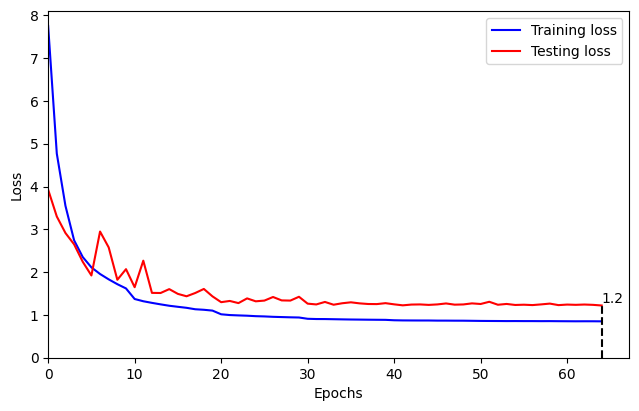

Traing epoch: 65   avg loss is: 0.8502868621342644
Testing epoch: 65   avg testing loss is: 1.2399631597542689
Testing on epoch: 65 has accuracy: top1: 89.35 top5: 98.40
Precision: 90.03%, Recall: 89.54%, F1 Score: 89.34%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


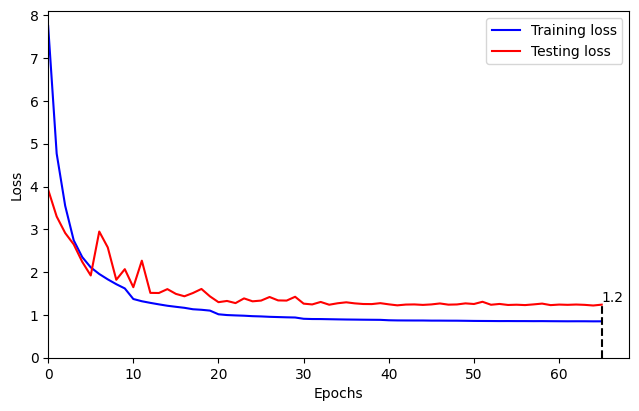

Traing epoch: 66   avg loss is: 0.8500710390682417
Testing epoch: 66   avg testing loss is: 1.2427572500297213
Testing on epoch: 66 has accuracy: top1: 89.08 top5: 98.38
Precision: 89.80%, Recall: 89.29%, F1 Score: 89.10%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


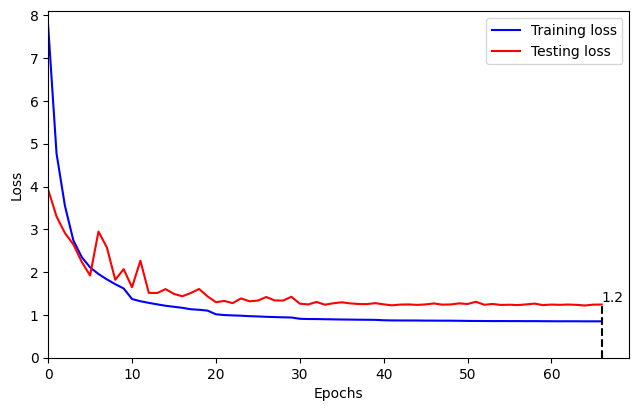

Traing epoch: 67   avg loss is: 0.8499070515802132
Testing epoch: 67   avg testing loss is: 1.250624665404406
Testing on epoch: 67 has accuracy: top1: 88.92 top5: 98.28
Precision: 89.60%, Recall: 89.10%, F1 Score: 88.84%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


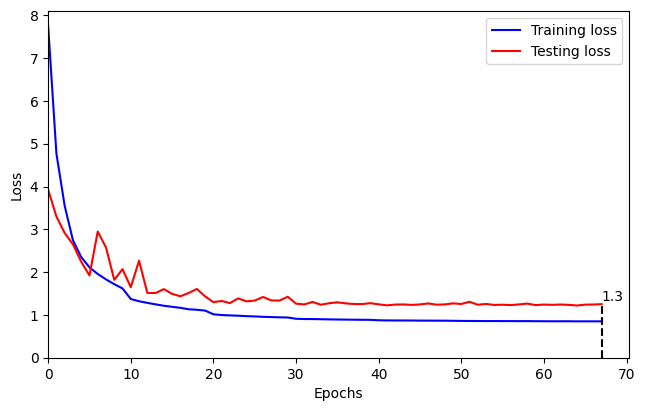

Traing epoch: 68   avg loss is: 0.8494019863536361
Testing epoch: 68   avg testing loss is: 1.2217837243436653
Testing on epoch: 68 has accuracy: top1: 89.97 top5: 98.60
Precision: 90.56%, Recall: 90.17%, F1 Score: 89.99%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


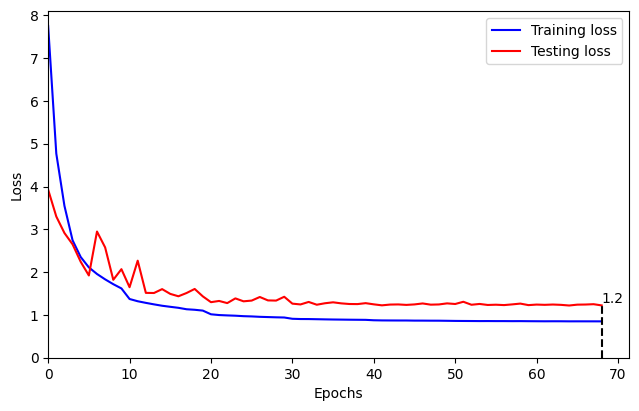

Traing epoch: 69   avg loss is: 0.8495368242152279
Testing epoch: 69   avg testing loss is: 1.2191337211481137
Testing on epoch: 69 has accuracy: top1: 89.92 top5: 98.58
Precision: 90.50%, Recall: 90.05%, F1 Score: 89.88%


/tmp/ipykernel_24/2973211049.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/2973211049.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


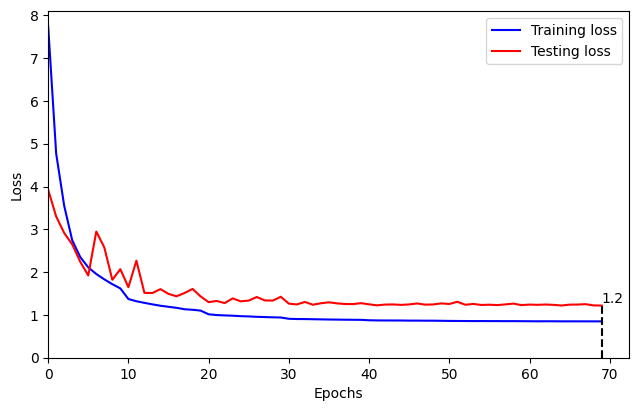

In [4]:
class DeepWriter_Train:
    def __init__(self,dataset='CERUG-EN',imgtype='png'):

        self.dataset = dataset
        self.folder = dataset
        #self.labelfolder = 'dataset/'

        if not os.path.exists(self.folder):
            if dataset == 'CERUG-EN':
                pass
                #download_cerug(dataset)
            elif dataset == 'Firemaker':
                download_firemaker(dataset)
            else:
                print('****** Warning: the dataset %s does not existed!******'%dataset)
                print('Please go to the following website to check how to download the dataset:')
                print('https://www.ai.rug.nl/~sheng/writeridataset.html')
                print('*'*20)
                raise ValueError('Dataset: %s does not existed!'%dataset)

        self.labelfolder = self.folder
        #self.train_folder = self.folder+'/train/'
        
        source_folder = '/kaggle/input/cerug-en/CERUG-EN-train-images/'
        destination_folder = '/kaggle/working/'

        # Copy the contents
        copy_folder_contents(source_folder, destination_folder)
        
        self.train_folder = destination_folder+'/train/'
        
        transformer = ImageTransformer(foldername=self.train_folder)
        transformer.process_and_save_images()
        
        #self.test_folder = self.folder+'/test/'
        self.test_folder = '/kaggle/input/cerug-en/CERUG-EN-test-images/test/'

        self.imgtype=imgtype
        self.device = 'cuda'
        self.scale_size=(64,128)

        if self.device == 'cuda':
            torch.backends.cudnn.benchmark = True

        if self.dataset == 'CVL':
            self.imgtype = 'tif'

        self.model_dir = 'model'
        if not os.path.exists(self.model_dir):
            #raise ValueError('Model directory: %s does not existed'%self.model_dir)
            os.mkdir(self.model_dir)#raise ValueError('Model directory: %s does not existed'%self.model_dir)

        basedir = 'GRRNN_WriterIdentification_dataset_'+self.dataset+'_model'
        self.logfile= basedir + '.log'
        self.modelfile = basedir
        self.batch_size = 16

        train_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.train_folder,
                        imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = True)

        self.training_data_loader = DataLoader(dataset=train_set, num_workers=0,
                           batch_size=self.batch_size, shuffle=True, drop_last=True)

        test_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.test_folder,imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = False)

        self.testing_data_loader = DataLoader(dataset=test_set, num_workers=0,
                           batch_size=self.batch_size, shuffle=False)

        num_class = train_set.num_writer
        self.model = GrnnNet(1,num_classes=train_set.num_writer).to(self.device)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = LabelSomCE()
        self.optimizer = optim.Adam(self.model.parameters(),lr=0.0001,weight_decay=1e-4)
        self.scheduler = lr_scheduler.StepLR(self.optimizer,step_size=10,gamma=0.5)

    def train(self,epoch):
        self.model.train()
        losstotal = []

        total_batches = len(self.training_data_loader)

        for iteration,batch in enumerate(self.training_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].type(torch.long).to(self.device)


            self.optimizer.zero_grad()

            logits = self.model(inputs)

            train_loss= self.criterion(logits,target)

            losstotal.append(train_loss.item())
            train_loss.backward()
            self.optimizer.step()


        with open(self.logfile,'a') as fp:
            fp.write('Training epoch %d avg loss is: %.6f\n'%(epoch,np.mean(losstotal)))
        print('Traing epoch:',epoch,'  avg loss is:',np.mean(losstotal))
        return np.mean(losstotal)


    def test(self,epoch,during_train=True):
        self.model.eval()
        losstotal = []

        if not during_train:
            self.load_model(epoch)

        top1 = 0
        top5 = 0
        ntotal=0
        
        all_preds = []
        all_targets = []

        for iteration,batch in enumerate(self.testing_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].to(self.device).long()

            logits = self.model(inputs)

            test_loss = self.criterion(logits,target)

            losstotal.append(test_loss.item())

            res = self.accuracy(logits,target,topk=(1,5))
            top1 += res[0]
            top5 += res[1]

            ntotal += inputs.size(0)
            
            _, preds = logits.topk(1, 1, True, True)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())


        top1 /= float(ntotal)
        top5 /= float(ntotal)
        
        precision, recall, f1 = self.compute_metrics(all_preds, all_targets)

        print('Testing epoch:',epoch,'  avg testing loss is:',np.mean(losstotal))
        print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
        print('Precision: %.2f%%, Recall: %.2f%%, F1 Score: %.2f%%' % (precision * 100, recall * 100, f1 * 100))
        with open(self.logfile,'a') as fp:
            fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))

        return np.mean(losstotal)

    def check_exists(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        return os.path.exists(model_out_path)

    def checkpoint(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        torch.save(self.model.state_dict(),model_out_path)


    def load_model(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        self.model.load_state_dict(torch.load(model_out_path,map_location=self.device))
        print('Load model successful')


    def plot_losses(self, training_losses, testing_losses):
        indices = range(len(training_losses))
        plt.figure(figsize=(7.5, 4.5))
        plt.plot(indices, training_losses, 'b', label='Training loss')
        plt.plot(indices, testing_losses, 'r', label='Testing loss')
        #plt.title('Training and Testing Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.xlim(left=0)
        plt.ylim(bottom=0)

        last_epoch = indices[-1]
        last_test_loss = testing_losses[-1]
        plt.plot([last_epoch, last_epoch], [0, last_test_loss], 'k--')
        plt.text(last_epoch, last_test_loss, f'{last_test_loss:.1f}', color='k', va='bottom', ha='left')
        plt.savefig("/kaggle/working/loss_plot.svg", format="svg", dpi=300)


        plt.show()


    def train_loops(self,start_epoch,num_epoch):
        #if self.check_exists(num_epoch): return
        if start_epoch > 0:
            self.load_model(start_epoch-1)

        training_losses = []
        testing_losses = []

        for epoch in range(start_epoch,num_epoch):

            train_loss = self.train(epoch)
            training_losses.append(train_loss)
            self.checkpoint(epoch)
            test_loss = self.test(epoch)
            testing_losses.append(test_loss)
            self.scheduler.step()
            self.plot_losses(training_losses, testing_losses)


    def accuracy(self,output,target,topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            _,pred = output.topk(maxk,1,True,True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.data.cpu().numpy())

        return res
    
    def compute_metrics(self, preds, targets):
        precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='macro')
        return precision, recall, f1


if __name__ == '__main__':
    mod = DeepWriter_Train(dataset='CERUG-EN')
    mod.train_loops(0,70)